In [1]:
!pip install pandas
!pip install shap

In [2]:
import os
import pandas as pd
import sqlite3
import warnings

# Suppress openpyxl warning
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

# Data path configuration
base_path = r'C:/Users/kk/Desktop/UCL/0008-Dissertation/DATA'
db_path = os.path.join(base_path, 'mydata.db')
conn = sqlite3.connect(db_path)

# Define all data files
data_files = {
    'basicinfo.xlsx': 'basicinfo',
    'finance_balance.xlsx': 'finance_balance',
    'finance_income.xlsx': 'finance_income',
    'board_structure.xlsx': 'board_structure',
    'governance.xlsx': 'governance',
    'audit.xlsx': 'audit',
    'analyst.xlsx': 'analyst',
    'volatility.xlsx': 'volatility',
    'turnover.xlsx': 'turnover',
    'shareholders.xlsx': 'shareholders',
    'instituinvest.xlsx': 'instituinvest',
    'illegal.xlsx': 'illegal',
    'forecast': ['forecast10-17.xlsx', 'forecast18-21.xlsx', 'forecast21-24.xlsx']  # Multiple files
}

# Import all data
for key, value in data_files.items():
    if isinstance(value, list):  # Multiple files to merge
        dfs = []
        for file_name in value:
            file_path = os.path.join(base_path, file_name)
            if os.path.exists(file_path):
                dfs.append(pd.read_excel(file_path))
        if dfs:
            df = pd.concat(dfs, ignore_index=True)
            df.to_sql(key, conn, if_exists='replace', index=False)
            print(f'{key} merged and imported')
    else:  # Single file
        file_path = os.path.join(base_path, key)
        if os.path.exists(file_path):
            df = pd.read_excel(file_path)
            df.to_sql(value, conn, if_exists='replace', index=False)
            print(f'{value} imported')

conn.close()

basicinfo imported
finance_balance imported
finance_income imported
board_structure imported
governance imported
audit imported
analyst imported
volatility imported
turnover imported
shareholders imported
instituinvest imported
illegal imported
forecast merged and imported


In [3]:
import sqlite3
import pandas as pd

# Database connection
db_path = r'C:/Users/kk/Desktop/UCL/0008-Dissertation/DATA/mydata.db'
conn = sqlite3.connect(db_path)

# Verify tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print('Tables in database:', tables['name'].tolist())

Tables in database: ['basicinfo', 'finance_balance', 'finance_income', 'board_structure', 'governance', 'audit', 'analyst', 'volatility', 'turnover', 'shareholders', 'instituinvest', 'illegal', 'forecast']


In [4]:
# ========== STAGE 1: DATA EXTRACTION ==========
def get_table(query):
    return pd.read_sql_query(query, conn)

# 1. board_structure
df_board = get_table("""
SELECT 
    Symbol AS stock_code,
    substr(Enddate, 1, 4) AS year,
    DirectorNumber,
    IndependentDirectorNumber,
    FemaleDirectorNumber,
    Top3DirectorSumSalary,
    Top3ManageSumSalary
FROM board_structure
WHERE Enddate LIKE '%12-31%' AND substr(Enddate, 1, 4) BETWEEN '2015' AND '2024'
""")

# 2. governance
df_governance = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Annodt, 1, 4) AS year,
    ChairmanHoldsharesRatio,
    ManagerHoldsharesRatio,
    Y1001b
FROM governance
WHERE substr(Annodt, 1, 4) BETWEEN '2015' AND '2024'
""")

# 3. finance_balance
df_fb = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Accper, 1, 4) AS year,
    A001101000 AS CashEq,
    A001000000 AS TotalAsset,
    A002000000 AS TotalLiab
FROM finance_balance
WHERE Accper LIKE '%12-31%' AND substr(Accper, 1, 4) BETWEEN '2015' AND '2024'
""")

# 4. finance_income
df_fi = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Accper, 1, 4) AS year,
    B001100000 AS Revenue,
    B001300000 AS NetProfit,
    B001210000 AS AdminExp,
    B001216000 AS RDExp
FROM finance_income
WHERE Accper LIKE '%12-31%' AND substr(Accper, 1, 4) BETWEEN '2015' AND '2024'
""")

# 5. basicinfo
df_basic = get_table("""
SELECT 
    Symbol AS stock_code,
    EstablishDate,
    IndustryCode
FROM basicinfo
""")

# 6. turnover
df_turnover = get_table("""
SELECT 
    Stkcd AS stock_code,
    Trdynt AS year,
    ToverOsY AS StocTO
FROM turnover
WHERE Trdynt BETWEEN 2015 AND 2024
""")

# 7. volatility
df_vola = get_table("""
SELECT 
    Stkcd AS stock_code,
    Trdynt AS year,
    Yretwd AS StoVola
FROM volatility
WHERE Trdynt BETWEEN 2015 AND 2024
""")

# 8. audit
df_audit = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Accper, 1, 4) AS year,
    Auditor,
    Iadtunit
FROM audit
WHERE Accper LIKE '%12-31%' AND substr(Accper, 1, 4) BETWEEN '2015' AND '2024'
""")

# 9. analyst
df_analyst = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Accper, 1, 4) AS year,
    AnaAttention,
    ReportAttention
FROM analyst
WHERE substr(Accper, 1, 4) BETWEEN '2015' AND '2024'
""")

# 10. instituinvest
df_ins = get_table("""
SELECT 
    Symbol AS stock_code,
    substr(EndDate, 1, 4) AS year,
    InsInvestorProp AS InstituInvestRatio
FROM instituinvest
WHERE substr(EndDate, 1, 4) BETWEEN '2015' AND '2024'
""")

# 11. shareholders
df_share = get_table("""
SELECT 
    Stkcd AS stock_code,
    substr(Reptdt, 1, 4) AS year,
    Shrcr1,
    Shrhfd5
FROM shareholders
WHERE Reptdt LIKE '%12-31%' AND substr(Reptdt, 1, 4) BETWEEN '2015' AND '2024'
""")

# 12. illegal (target variable)
df_illegal = get_table("""
SELECT 
    Symbol AS stock_code,
    ViolationYear AS year,
    IsViolated
FROM illegal
WHERE ViolationYear BETWEEN 2015 AND 2024
""")

# 13. forecast
df_forecast = get_table("""
SELECT 
    Stkcd,
    Fenddt,
    Feps
FROM forecast
""")

print('Data extraction completed')

Data extraction completed


In [5]:
# ========== STAGE 2: DATA INTEGRATION ==========
import pandas as pd
import numpy as np

# Standardize data types for merging
tables = [df_illegal, df_board, df_governance, df_fb, df_fi, df_turnover, 
         df_vola, df_audit, df_analyst, df_ins, df_share, df_forecast]

for df in tables:
   if df is not None and not df.empty:
       if 'year' in df.columns:
           df['year'] = df['year'].astype(str)
       if 'stock_code' in df.columns:
           df['stock_code'] = df['stock_code'].astype(str)

df_basic['stock_code'] = df_basic['stock_code'].astype(str)

# Remove duplicates from each table
df_fb_clean = df_fb.drop_duplicates(['stock_code', 'year'], keep='first')
df_fi_clean = df_fi.drop_duplicates(['stock_code', 'year'], keep='first')
df_board_clean = df_board.drop_duplicates(['stock_code', 'year'], keep='first')
df_governance_clean = df_governance.drop_duplicates(['stock_code', 'year'], keep='first')
df_turnover_clean = df_turnover.drop_duplicates(['stock_code', 'year'], keep='first')
df_vola_clean = df_vola.drop_duplicates(['stock_code', 'year'], keep='first')
df_audit_clean = df_audit.drop_duplicates(['stock_code', 'year'], keep='first')
df_analyst_clean = df_analyst.drop_duplicates(['stock_code', 'year'], keep='first')
df_ins_clean = df_ins.drop_duplicates(['stock_code', 'year'], keep='first')
df_share_clean = df_share.drop_duplicates(['stock_code', 'year'], keep='first')
df_illegal_clean = df_illegal.drop_duplicates(['stock_code', 'year'], keep='first')
df_basic_clean = df_basic.drop_duplicates(['stock_code'], keep='first')

# Merge all tables using finance_balance as base
df_all = df_fb_clean.merge(df_fi_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_board_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_governance_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_turnover_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_vola_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_audit_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_analyst_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_ins_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_share_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_illegal_clean, on=['stock_code', 'year'], how='left')
df_all = df_all.merge(df_basic_clean, on=['stock_code'], how='left')

print(f"Data integration completed: {len(df_all)} rows, {len(df_all.columns)} columns")

Data integration completed: 43291 rows, 29 columns


In [6]:
# ========== STAGE 3: COMPUTATION OF DERIVED VARIABLES ==========
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Ensure numeric types before calculations
cols_to_convert = [
    'TotalAsset', 'NetProfit', 'TotalLiab', 'CashEq', 'RDExp',
    'IndependentDirectorNumber', 'DirectorNumber', 'FemaleDirectorNumber',
    'Top3DirectorSumSalary', 'Top3ManageSumSalary', 'Y1001b', 'Revenue'
]
df_all[cols_to_convert] = df_all[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# 1. Target variable (Misconduct)
df_all['IsViolated'] = df_all['IsViolated'].str.upper().str.strip()
df_all['Misconduct'] = df_all['IsViolated'].map({'Y': 1, 'N': 0}).fillna(0).astype(int)

# 2. Basic transformations
df_all['EstablishYear'] = pd.to_datetime(df_all['EstablishDate'], errors='coerce').dt.year
df_all['FirmAge'] = df_all['year'].astype(int) - df_all['EstablishYear']
df_all['LnAsset'] = np.log(df_all['TotalAsset'].replace(0, np.nan))

# 3. Financial ratios
df_all['ROA'] = df_all['NetProfit'] / df_all['TotalAsset']
df_all['Lev'] = df_all['TotalLiab'] / df_all['TotalAsset']
df_all['Slack1'] = df_all['CashEq'] / df_all['TotalAsset']
df_all['RDExpRatio'] = df_all['RDExp'] / df_all['TotalAsset']
df_all = df_all.sort_values(['stock_code', 'year'])
df_all['Growth'] = df_all.groupby('stock_code')['Revenue'].pct_change()

# 4. Governance variables
df_all['IndepDiRatio'] = df_all['IndependentDirectorNumber'] / df_all['DirectorNumber']
df_all['FemDiRatio'] = df_all['FemaleDirectorNumber'] / df_all['DirectorNumber']
df_all['lnTop3DirectorSumSalary'] = np.log(df_all['Top3DirectorSumSalary'].replace(0, np.nan))
df_all['lnTop3ManageSumSalary'] = np.log(df_all['Top3ManageSumSalary'].replace(0, np.nan))

# 5. Duality (Chairman-CEO)
conditions = [(df_all['Y1001b'] == 1), (df_all['Y1001b'] == 2)]
choices = [1, 0]
df_all['Duality'] = np.select(conditions, choices, default=-1)

# 6. Audit variables
df_all['Big4n'] = df_all['Auditor'].str.contains('Big4|PWC|Deloitte|EY|KPMG', case=False, na=False).astype(int)
df_all['Outsiden'] = df_all['Iadtunit'].notna().astype(int)

# 7. Market uncertainty
df_forecast['Stkcd'] = df_forecast['Stkcd'].astype(str).str.zfill(6)
df_forecast['Fenddt'] = pd.to_datetime(df_forecast['Fenddt'], errors='coerce')
df_forecast = df_forecast[df_forecast['Fenddt'].notna()].copy()
df_forecast['year'] = df_forecast['Fenddt'].dt.year.astype('Int64')
df_forecast = df_forecast[df_forecast['year'].between(2015, 2024)]
df_forecast['year'] = df_forecast['year'].astype(str)

firm_std = df_forecast.groupby(['Stkcd', 'year'])['Feps'].std().reset_index(name='FirmForecastSTD')
firm_std = firm_std.merge(df_all[['stock_code', 'IndustryCode']], 
                          left_on='Stkcd', right_on='stock_code', how='left')
industry_uncertainty = firm_std.groupby(['IndustryCode', 'year'])['FirmForecastSTD'].median().reset_index(name='MarketUncertainty')
df_all = df_all.merge(industry_uncertainty, on=['IndustryCode', 'year'], how='left')

print(f"Derived variables computed: {len(df_all.columns)} total features")

Derived variables computed: 46 total features


In [7]:
# ========== STAGE 4: DATA PREPROCESSING ==========
# Includes missing value imputation, outlier mitigation, and feature scaling.

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

print("Initial sample shape:", df_all.shape)
df_all.drop_duplicates(inplace=True)

# --- Missing value imputation ---

# Fill 0 for structural absence
fill_zero = ['RDExp', 'RDExpRatio', 'AnaAttention', 'ReportAttention', 
             'ChairmanHoldsharesRatio', 'ManagerHoldsharesRatio']
for col in fill_zero:
    if col in df_all.columns:
        df_all[col] = df_all[col].fillna(0)

# Yearly median imputation for numeric features
group_vars = ['ROA', 'Lev', 'Slack1', 'LnAsset', 'CashEq', 'TotalAsset', 'TotalLiab', 'NetProfit', 'AdminExp',
              'DirectorNumber', 'IndependentDirectorNumber', 'FemDiRatio', 'IndepDiRatio', 'Big4n', 'Outsiden',
              'StocTO', 'StoVola', 'InstituInvestRatio', 'MarketUncertainty',
              'lnTop3DirectorSumSalary', 'lnTop3ManageSumSalary',
              'Shrcr1', 'Shrcr2', 'Shrhfd5', 'FemaleDirectorNumber', 'Revenue']
for col in group_vars:
    if col in df_all.columns:
        df_all[col] = df_all.groupby('year')[col].transform(lambda x: x.fillna(x.median()))
        df_all[col] = df_all[col].fillna(df_all[col].median())

# Field-specific imputation for uncovered variables
if 'Top3DirectorSumSalary' in df_all.columns:
    df_all['Top3DirectorSumSalary'] = df_all.groupby('year')['Top3DirectorSumSalary'].transform(lambda x: x.fillna(x.median()))
    df_all['Top3DirectorSumSalary'] = df_all['Top3DirectorSumSalary'].fillna(df_all['Top3DirectorSumSalary'].median())

if 'Top3ManageSumSalary' in df_all.columns:
    df_all['Top3ManageSumSalary'] = df_all.groupby('year')['Top3ManageSumSalary'].transform(lambda x: x.fillna(x.median()))
    df_all['Top3ManageSumSalary'] = df_all['Top3ManageSumSalary'].fillna(df_all['Top3ManageSumSalary'].median())

if 'Y1001b' in df_all.columns:
    df_all['Y1001b'] = pd.to_numeric(df_all['Y1001b'], errors='coerce').fillna(0)

if 'Auditor' in df_all.columns:
    df_all['Auditor'] = df_all['Auditor'].fillna('Unknown')

if 'Iadtunit' in df_all.columns:
    df_all['Iadtunit'] = df_all['Iadtunit'].fillna('None')

if 'IsViolated' in df_all.columns:
    df_all['IsViolated'] = df_all['IsViolated'].fillna('N')

if 'MarketUncertainty_x' in df_all.columns and 'MarketUncertainty_y' in df_all.columns:
    df_all.drop(columns=['MarketUncertainty_y'], inplace=True)
    df_all.rename(columns={'MarketUncertainty_x': 'MarketUncertainty'}, inplace=True)
    df_all['MarketUncertainty'] = df_all.groupby('year')['MarketUncertainty'].transform(lambda x: x.fillna(x.median()))
    df_all['MarketUncertainty'] = df_all['MarketUncertainty'].fillna(df_all['MarketUncertainty'].median())

if 'Growth' in df_all.columns:
   df_all.loc[np.isinf(df_all['Growth']), 'Growth'] = np.nan
   df_all['Growth'] = df_all['Growth'].fillna(0)

# Target variable (ensure complete)
df_all['Misconduct'] = df_all['Misconduct'].fillna(0).astype(int)

# --- Outlier treatment and standardization ---

def winsorize(series, lower=0.01, upper=0.99):
    return series.clip(lower=series.quantile(lower), upper=series.quantile(upper))

scaler = StandardScaler()
winsorized_vars = []

for col in df_all.columns:
    if pd.api.types.is_numeric_dtype(df_all[col]):
        s = df_all[col]
        unique_vals = s.dropna().unique()
        if set(unique_vals).issubset({0, 1}): continue
        if s.max() <= 1.5 and s.min() >= 0: continue

        q1, q99 = s.quantile(0.01), s.quantile(0.99)
        std = s.std() + 1e-6
        if (q99 - q1) / std > 5:
            df_all[col] = winsorize(s)
            winsorized_vars.append(col)

        df_all[col] = scaler.fit_transform(df_all[[col]]).flatten()
        
# --- Summary ---
print("Data preprocessing completed.")
print(f"Final dataset shape: {df_all.shape[0]:,} rows × {df_all.shape[1]:,} columns")
print(f"Remaining missing values: {df_all.isnull().sum().sum()}")
print(f"Winsorized variables ({len(winsorized_vars)}): {winsorized_vars}")
print(f"Misconduct rate (1=violation): {df_all['Misconduct'].mean():.2%}")

Initial sample shape: (43291, 46)
Data preprocessing completed.
Final dataset shape: 43,291 rows × 46 columns
Remaining missing values: 0
Winsorized variables (3): ['LnAsset', 'lnTop3DirectorSumSalary', 'lnTop3ManageSumSalary']
Misconduct rate (1=violation): 6.72%


Dataset: 43,291 firms, 340 industries
Misconduct rate: 6.72%
Time span: 2015–2024

Top 5 Significant Differences between Groups:
Identified 19 significant predictors (p<0.01)
1. ROA                  ↓ in misconduct firms (p=0.0000)
2. lnTop3ManageSumSalary ↓ in misconduct firms (p=0.0000)
3. lnTop3DirectorSumSalary ↓ in misconduct firms (p=0.0000)
4. Duality              ↑ in misconduct firms (p=0.0000)
5. Y1001b               ↑ in misconduct firms (p=0.0000)

Industry-level Misconduct Risk:
Highest: A0920 (30.0%)
Lowest:  B0301 (0.0%)
Range:   0.0% – 30.0%

Top 5 Predictors by Correlation with Misconduct:
1. ROA                  -0.067
2. lnTop3ManageSumSalary -0.067
3. lnTop3DirectorSumSalary -0.066
4. Slack1               -0.065
5. Duality              +0.050


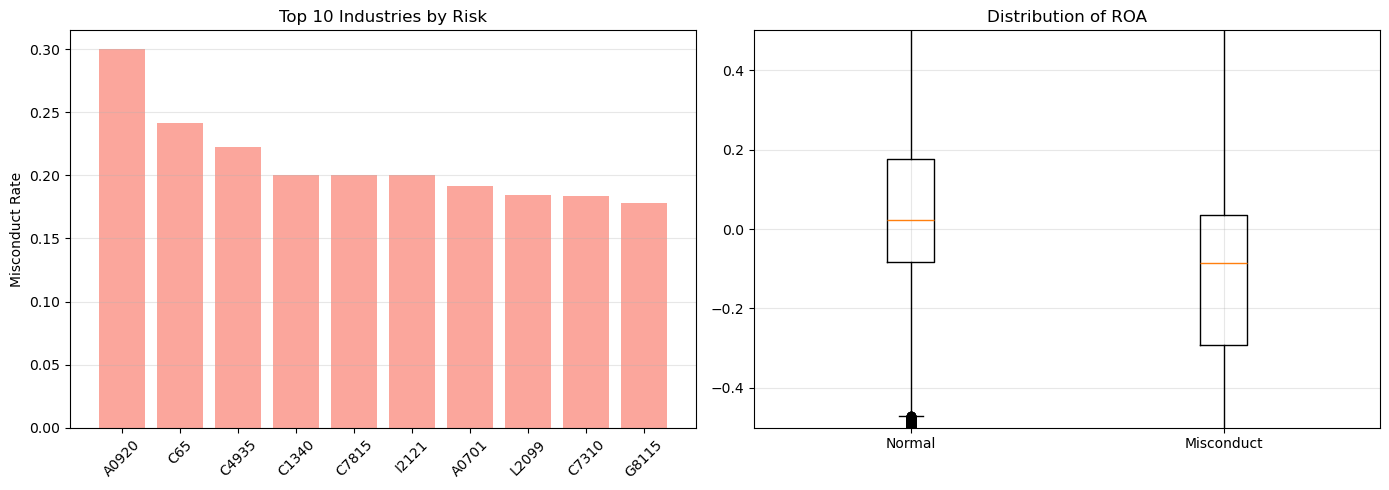


Summary: 19 features show significant group differences.
Industry risk: 0.0% to 30.0%


In [8]:
# ========== STAGE 5: DESCRIPTIVE STATISTICS ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Define numeric features
exclude_cols = ['stock_code', 'year', 'Misconduct', 'EndDate', 'Symbol', 'IndustryCode']
numeric_cols = [col for col in df_all.columns 
                if col not in exclude_cols and df_all[col].dtype in ['int64', 'float64']]

# 1. Overview
print(f"Dataset: {len(df_all):,} firms, {df_all['IndustryCode'].nunique()} industries")
print(f"Misconduct rate: {df_all['Misconduct'].mean():.2%}")
print(f"Time span: {df_all['year'].min()}–{df_all['year'].max()}")

# 2. Group difference (Misconduct vs. Normal)
print("\nTop 5 Significant Differences between Groups:")
significant_diffs = []
for col in numeric_cols:
    group_m = df_all[df_all['Misconduct'] == 1][col].dropna()
    group_n = df_all[df_all['Misconduct'] == 0][col].dropna()
    if len(group_m) > 10 and len(group_n) > 10:
        t_stat, p_value = stats.ttest_ind(group_m, group_n)
        if p_value < 0.01:
            diff = abs(group_m.mean() - group_n.mean())
            significant_diffs.append((col, p_value, diff, group_m.mean(), group_n.mean()))
significant_diffs.sort(key=lambda x: x[2], reverse=True)

print(f"Identified {len(significant_diffs)} significant predictors (p<0.01)")
for i, (col, p_val, diff, m_mean, n_mean) in enumerate(significant_diffs[:5], 1):
    direction = "↑" if m_mean > n_mean else "↓"
    print(f"{i}. {col:<20} {direction} in misconduct firms (p={p_val:.4f})")

# 3. Industry-level misconduct risk
print("\nIndustry-level Misconduct Risk:")
industry_risk = df_all.groupby('IndustryCode')['Misconduct'].agg(['count', 'mean'])
industry_risk = industry_risk[industry_risk['count'] >= 20]
high_risk = industry_risk.nlargest(3, 'mean')
low_risk = industry_risk.nsmallest(3, 'mean')

print(f"Highest: {high_risk.index[0]} ({high_risk.iloc[0]['mean']:.1%})")
print(f"Lowest:  {low_risk.index[0]} ({low_risk.iloc[0]['mean']:.1%})")
print(f"Range:   {low_risk['mean'].min():.1%} – {high_risk['mean'].max():.1%}")

# 4. Correlation with misconduct
print("\nTop 5 Predictors by Correlation with Misconduct:")
correlations = df_all[numeric_cols].corrwith(df_all['Misconduct']).sort_values(key=abs, ascending=False)
for i, (feat, corr) in enumerate(correlations.head(5).items(), 1):
    sign = "+" if corr > 0 else "-"
    print(f"{i}. {feat:<20} {sign}{abs(corr):.3f}")

# 5. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 5.1 Top 10 industries
industry_plot = industry_risk.sort_values('mean', ascending=False).head(10)
ax1.bar(range(len(industry_plot)), industry_plot['mean'], color='salmon', alpha=0.7)
ax1.set_xticks(range(len(industry_plot)))
ax1.set_xticklabels(industry_plot.index, rotation=45)
ax1.set_ylabel('Misconduct Rate')
ax1.set_title('Top 10 Industries by Risk')
ax1.grid(axis='y', alpha=0.3)

# 5.2 Boxplot of top feature
top_feature = "ROA"
data_m = df_all[df_all['Misconduct'] == 1][top_feature].dropna()
data_n = df_all[df_all['Misconduct'] == 0][top_feature].dropna()
ax2.boxplot([data_n, data_m], labels=['Normal', 'Misconduct'])
ax2.set_title(f'Distribution of {top_feature}')
ax2.set_ylim(-0.5, 0.5)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Missing value check
missing_rates = df_all[numeric_cols].isnull().mean()
high_missing = missing_rates[missing_rates > 0.1]
if len(high_missing) > 0:
    print("\nWarning: High missing rate in variables:", list(high_missing.index))

print(f"\nSummary: {len(significant_diffs)} features show significant group differences.")
if low_risk['mean'].min() > 0:
    ratio = high_risk['mean'].max() / low_risk['mean'].min()
    print(f"Industry-level risk varies by {ratio:.1f}x.")
else:
    print(f"Industry risk: {low_risk['mean'].min():.1%} to {high_risk['mean'].max():.1%}")
print("=" * 60)

In [9]:
# ========== STAGE 6: Machine Learning Modeling ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, average_precision_score
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. Select variables
selected_features = [
    'DirectorNumber', 'IndependentDirectorNumber', 'IndepDiRatio', 'Duality',
    'ChairmanHoldsharesRatio', 'ManagerHoldsharesRatio',
    'FemDiRatio', 'lnTop3DirectorSumSalary', 'lnTop3ManageSumSalary',
    'ROA', 'Lev', 'Slack1', 'RDExpRatio', 'LnAsset', 'FirmAge',
    'StocTO', 'StoVola', 'Big4n', 'AnaAttention', 'InstituInvestRatio',
    'MarketUncertainty', 'Shrcr1', 'Shrhfd5'
]

X = df_all[selected_features].copy()
y = df_all['Misconduct']
X = X.astype(float)
print(f"Selected features: {len(selected_features)}, Samples: {len(X)}, Misconduct rate: {y.mean():.2%}")

# 2. Train-test split (time-based)
years = sorted(df_all['year'].unique())
split_idx = int(len(years) * 0.8)
train_mask = df_all['year'].isin(years[:split_idx])
X_train, X_test, y_train, y_test = X[train_mask], X[~train_mask], y[train_mask], y[~train_mask]
print(f"Train: {len(X_train)}, Test: {len(X_test)}, Train misconduct rate: {y_train.mean():.2%}")

# Ensure chronological order within training for time-series CV
train_years = df_all.loc[train_mask, 'year'].values
order_idx = np.argsort(train_years)
X_train = X_train.iloc[order_idx]
y_train = y_train.iloc[order_idx]

# 3. Hyperparameter tuning (time-series CV)
tscv = TimeSeriesSplit(n_splits=5)

param_rf = {
    'n_estimators': [200, 500, 800],
    'max_depth': [4, 6, 10, 14],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# XGBoost tuning
pos_weight = (len(y_train) - int(y_train.sum())) / max(int(y_train.sum()), 1)
param_xgb = {
    'n_estimators': [100, 300, 600],
    'max_depth': [3, 4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 3, 5]
}

def add_prefix(grid, prefix):
    return {f'{prefix}{k}': v for k, v in grid.items()}

# Tune RF/XGB under three strategies: class_weight, smote_tomek, both
tuned_models = {}
for method in ['class_weight', 'smote_tomek', 'both']:
    use_smote = (method in ['smote_tomek', 'both'])
    use_class_weight = (method in ['class_weight', 'both'])

    # Random Forest
    rf_base = RandomForestClassifier(
        class_weight=('balanced' if use_class_weight else None),
        random_state=42
    )
    if use_smote:
        rf_pipe = Pipeline([
            ('smote', SMOTETomek(random_state=42)),
            ('model', rf_base)
        ])
        rf_grid = GridSearchCV(
            rf_pipe, add_prefix(param_rf, 'model__'),
            cv=tscv, scoring='f1', n_jobs=-1
        )
    else:
        rf_grid = GridSearchCV(
            rf_base, param_rf,
            cv=tscv, scoring='f1', n_jobs=-1
        )
    rf_grid.fit(X_train, y_train)
    best_rf_m = rf_grid.best_estimator_
    print(f"Best RF parameters ({method}):", rf_grid.best_params_)

    # XGBoost
    xgb_base = xgb.XGBClassifier(
        scale_pos_weight=(pos_weight if use_class_weight else 1.0),
        random_state=42,
        eval_metric='logloss'
    )
    if use_smote:
        xgb_pipe = Pipeline([
            ('smote', SMOTETomek(random_state=42)),
            ('model', xgb_base)
        ])
        xgb_grid = GridSearchCV(
            xgb_pipe, add_prefix(param_xgb, 'model__'),
            cv=tscv, scoring='f1', n_jobs=-1
        )
    else:
        xgb_grid = GridSearchCV(
            xgb_base, param_xgb,
            cv=tscv, scoring='f1', n_jobs=-1
        )
    xgb_grid.fit(X_train, y_train)
    best_xgb_m = xgb_grid.best_estimator_
    print(f"Best XGBoost parameters ({method}):", xgb_grid.best_params_)

    tuned_models[method] = {'rf': best_rf_m, 'xgb': best_xgb_m}

# 4. Define models
# Logistic Regression is handled with/without SMOTE and with/without class weights via pipelines
def make_lr_pipeline(use_smote, use_class_weight):
    steps = []
    if use_smote:
        steps.append(('smote', SMOTETomek(random_state=42)))
    steps.append(('scaler', RobustScaler()))
    steps.append(('model', LogisticRegression(
        class_weight=('balanced' if use_class_weight else None),
        random_state=42, max_iter=2000, C=0.1
    )))
    return Pipeline(steps)

# 5. Evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, scaled=False):
    X_train_proc = X_train.values if hasattr(X_train, 'values') else X_train
    X_test_proc = X_test.values if hasattr(X_test, 'values') else X_test
    y_train_proc = y_train.values if hasattr(y_train, 'values') else y_train
    y_test_proc = y_test.values if hasattr(y_test, 'values') else y_test

    model.fit(X_train_proc, y_train_proc)
    y_proba = model.predict_proba(X_test_proc)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    # Top-K metrics
    k = max(20, int(len(y_test_proc) * 0.1))
    top_k_idx = np.argsort(y_proba)[::-1][:k]
    y_true_k = y_test_proc[top_k_idx] if isinstance(y_test_proc, np.ndarray) else y_test.iloc[top_k_idx].values
    dcg = np.sum([y_true_k[i] / np.log2(i + 2) for i in range(len(y_true_k))])
    total_pos = int(np.sum(y_test_proc))
    idcg = np.sum([1 / np.log2(i + 2) for i in range(min(k, total_pos))])
    ndcg_k = dcg / idcg if idcg > 0 else 0.0

    # Time-based CV for uncertainty
    cv = cross_val_score(model, X_train_proc, y_train_proc, cv=tscv, scoring='f1', n_jobs=-1)

    denom_k = k if k > 0 else 1
    recall_k_den = total_pos if total_pos > 0 else 1

    return {
        'model': model,
        'y_proba': y_proba,
        'y_pred': y_pred,
        'auc': roc_auc_score(y_test_proc, y_proba),
        'pr_auc': average_precision_score(y_test_proc, y_proba),
        'f1': f1_score(y_test_proc, y_pred),
        'precision': precision_score(y_test_proc, y_pred),
        'recall': recall_score(y_test_proc, y_pred),
        'ndcg_k': ndcg_k,
        'precision_k': float(np.sum(y_true_k)) / denom_k,
        'recall_k': float(np.sum(y_true_k)) / recall_k_den,
        'cv_f1_mean': cv.mean(),
        'cv_f1_std': cv.std(),
        'stability': f1_score(y_test_proc, y_pred) - cv.std()
    }

# 6. Model training under different resampling methods
results = {}
for method in ['class_weight', 'smote_tomek', 'both']:
    print(f"\n=== Resampling: {method} ===")
    use_smote = (method in ['smote_tomek', 'both'])
    use_class_weight = (method in ['class_weight', 'both'])

    # Build models for this method (SMOTE is applied only within training via Pipeline)
    best_rf = tuned_models[method]['rf']
    best_xgb = tuned_models[method]['xgb']

    lr_pipeline = make_lr_pipeline(use_smote=use_smote, use_class_weight=use_class_weight)

    models = {
        'Logistic Regression': (lr_pipeline, False),
        'Random Forest': (best_rf, False),
        'XGBoost': (best_xgb, False)
    }

    method_results = {}
    for name, (model, scaled) in models.items():
        print(f"{name}:")
        result = evaluate_model(model, X_train, y_train, X_test, y_test, scaled)
        method_results[name] = result
        print(f"AUC: {result['auc']:.3f}, PR AUC: {result['pr_auc']:.3f}, Precision: {result['precision']:.3f}, Recall: {result['recall']:.3f}, F1: {result['f1']:.3f}")
        print(f"NDCG@k: {result['ndcg_k']:.3f}, Precision@k: {result['precision_k']:.3f}, Recall@k: {result['recall_k']:.3f}")
        print(f"CV-F1 mean: {result['cv_f1_mean']:.3f}, CV-F1 std: {result['cv_f1_std']:.3f}, Stability: {result['stability']:.3f}")
    results[method] = method_results

# 7. Best configuration
all_configs = [(m, n, r['f1']) for m, res in results.items() for n, r in res.items()]
best_method, best_model_name, best_f1 = max(all_configs, key=lambda x: x[2])
best_result = results[best_method][best_model_name]
print(f"\nBest model: {best_method} + {best_model_name} (F1: {best_f1:.3f})")
print(f"AUC: {best_result['auc']:.3f}, PR AUC: {best_result['pr_auc']:.3f}, Precision: {best_result['precision']:.3f}, Recall: {best_result['recall']:.3f}, F1: {best_result['f1']:.3f}")
print(f"NDCG@k: {best_result['ndcg_k']:.3f}, Precision@k: {best_result['precision_k']:.3f}, Recall@k: {best_result['recall_k']:.3f}")
print(f"CV-F1 mean: {best_result['cv_f1_mean']:.3f}, CV-F1 std: {best_result['cv_f1_std']:.3f}, Stability: {best_result['stability']:.3f}")
print("Modeling process completed.")

Selected features: 23, Samples: 43291, Misconduct rate: 6.72%
Train: 32537, Test: 10754, Train misconduct rate: 7.39%
Best RF parameters (class_weight): {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 800}
Best XGBoost parameters (class_weight): {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.8}
Best RF parameters (smote_tomek): {'model__max_depth': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best XGBoost parameters (smote_tomek): {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 3, 'model__n_estimators': 300, 'model__subsample': 0.8}
Best RF parameters (both): {'model__max_depth': 6, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best XGBoost parameters (both): {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'mode

=== Visualization: Model Evaluation and Diagnostics ===


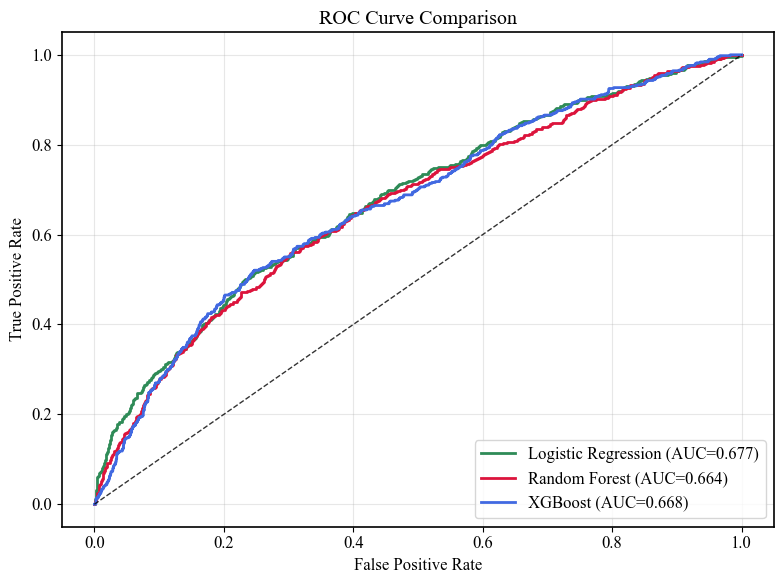

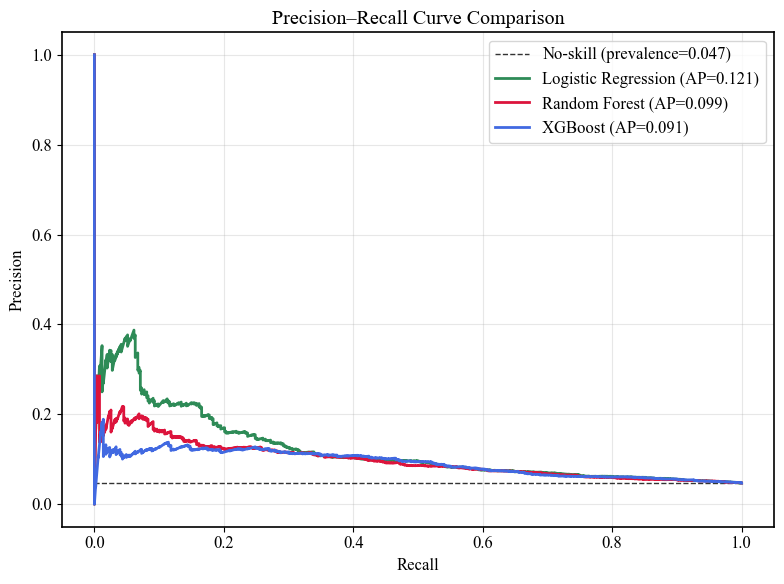

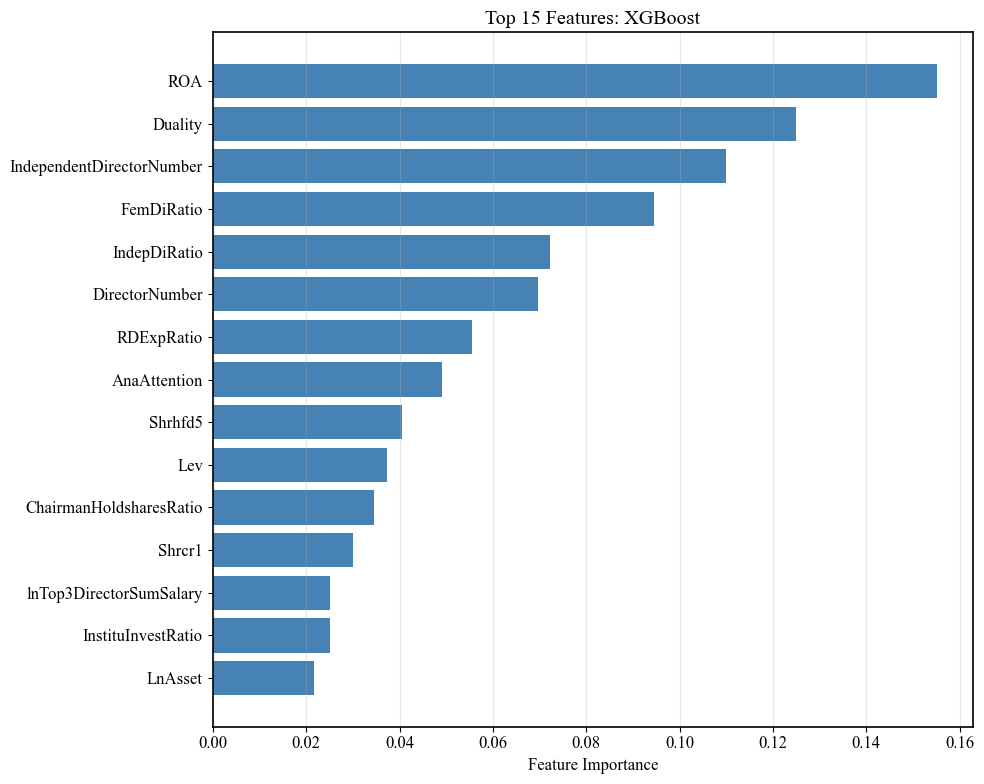

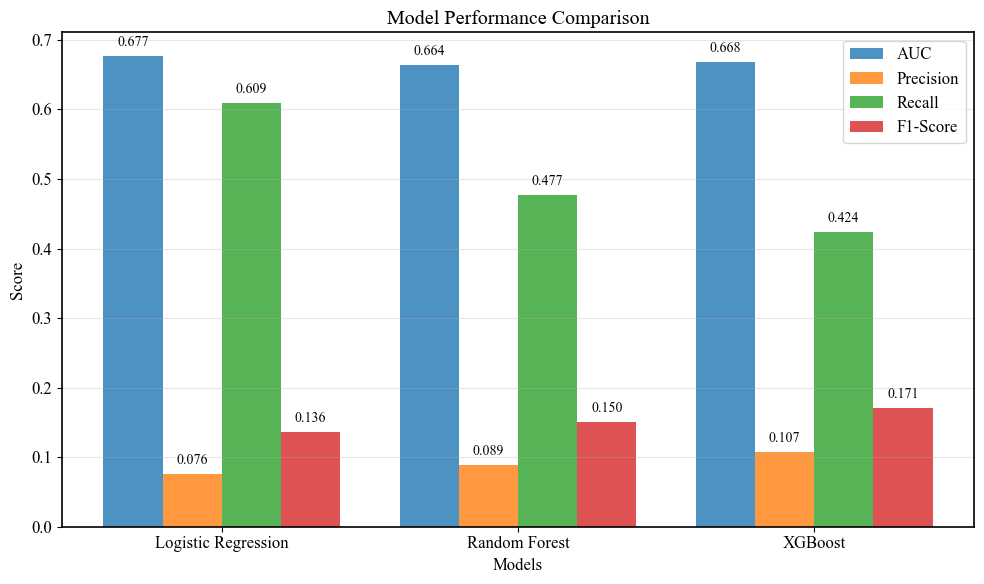

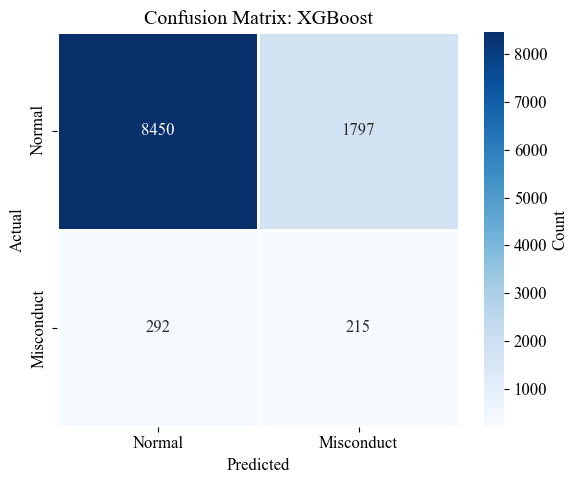

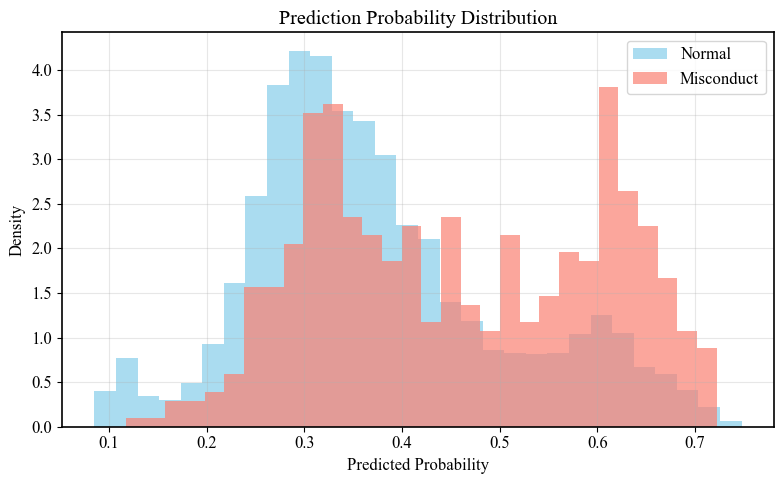

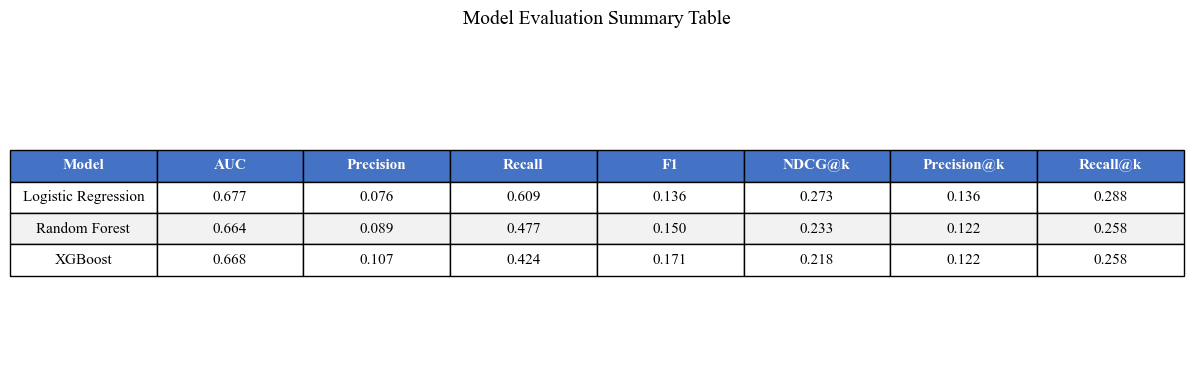


=== Summary of Evaluation Results ===
Best Model: smote_tomek + XGBoost
Test Set Size: 10754 (Misconduct: 507, Normal: 10247)
Performance: AUC = 0.668, F1 = 0.171
All charts generated successfully.


In [29]:
# ========== VISUALIZATION OF MODEL RESULTS ==========
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, confusion_matrix, precision_recall_curve, average_precision_score

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 12, 'axes.linewidth': 1.2})

print("=== Visualization: Model Evaluation and Diagnostics ===")

model_names = list(results[best_method].keys())
colors = ['#2E8B57', '#DC143C', '#4169E1']

# ROC Curves
plt.figure(figsize=(8, 6))
for i, name in enumerate(model_names):
    fpr, tpr, _ = roc_curve(y_test, results[best_method][name]['y_proba'])
    plt.plot(fpr, tpr, color=colors[i], lw=2, label=f"{name} (AUC={results[best_method][name]['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.8)
plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison'), plt.legend(loc='lower right')
plt.grid(alpha=0.3), plt.tight_layout()
plt.show()

# Precision-Recall Curve (with AP)
plt.figure(figsize=(8, 6))
no_skill = np.mean(y_test)  # prevalence as baseline
plt.hlines(no_skill, 0, 1, colors='k', linestyles='--', lw=1, label=f'No-skill (prevalence={no_skill:.3f})', alpha=0.8)
for i, name in enumerate(model_names):
    y_proba = results[best_method][name]['y_proba']
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)
    plt.plot(recall, precision, color=colors[i], lw=2, label=f"{name} (AP={ap:.3f})")
plt.xlabel('Recall'), plt.ylabel('Precision')
plt.title('Precision–Recall Curve Comparison')
plt.legend(loc='upper right')
plt.grid(alpha=0.3), plt.tight_layout()
plt.show()

# Feature Importance
pipeline = best_result.get('model')
if pipeline and hasattr(pipeline.named_steps['model'], 'feature_importances_'):
    model = pipeline.named_steps['model']
    fi = pd.DataFrame({
        'feature': selected_features,
        'importance': model.feature_importances_
    })
    fi = fi.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(fi['feature'], fi['importance'], color='steelblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top 15 Features: {best_model_name}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Performance Bar Plot (AUC, Precision, Recall, F1)
metrics = ['auc', 'precision', 'recall', 'f1']
labels = ['AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(10, 6))
for i, (metric, label) in enumerate(zip(metrics, labels)):
    values = [results[best_method][name][metric] for name in model_names]
    bars = plt.bar(x + i * width, values, width, label=label, alpha=0.8)
    for bar, v in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
plt.xticks(x + width * 1.5, model_names)
plt.xlabel('Models'), plt.ylabel('Score'), plt.title('Model Performance Comparison')
plt.legend(), plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, best_result['y_pred'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Misconduct'], yticklabels=['Normal', 'Misconduct'],
            linewidths=1, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted'), plt.ylabel('Actual')
plt.title(f'Confusion Matrix: {best_model_name}')
plt.tight_layout()
plt.show()

# Probability Distribution
plt.figure(figsize=(8, 5))
plt.hist(best_result['y_proba'][y_test == 0], bins=30, alpha=0.7, label='Normal', color='skyblue', density=True)
plt.hist(best_result['y_proba'][y_test == 1], bins=30, alpha=0.7, label='Misconduct', color='salmon', density=True)
plt.xlabel('Predicted Probability'), plt.ylabel('Density')
plt.title('Prediction Probability Distribution')
plt.legend(), plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Summary Table
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')
table_data = [[
    name,
    f"{results[best_method][name]['auc']:.3f}",
    f"{results[best_method][name]['precision']:.3f}",
    f"{results[best_method][name]['recall']:.3f}",
    f"{results[best_method][name]['f1']:.3f}",
    f"{results[best_method][name]['ndcg_k']:.3f}",
    f"{results[best_method][name]['precision_k']:.3f}",
    f"{results[best_method][name]['recall_k']:.3f}"
] for name in model_names]

table = ax.table(cellText=table_data,
                 colLabels=['Model', 'AUC', 'Precision', 'Recall', 'F1', 'NDCG@k', 'Precision@k', 'Recall@k'],
                 loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

for i in range(len(model_names) + 1):
    for j in range(8):
        cell = table[(i, j)]
        if i == 0:
            cell.set_facecolor('#4472C4')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#F2F2F2' if i % 2 == 0 else 'white')

plt.title('Model Evaluation Summary Table', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Summary Output
print("\n=== Summary of Evaluation Results ===")
print(f"Best Model: {best_method} + {best_model_name}")
print(f"Test Set Size: {len(y_test)} (Misconduct: {np.sum(y_test)}, Normal: {len(y_test) - np.sum(y_test)})")
print(f"Performance: AUC = {best_result['auc']:.3f}, F1 = {best_result['f1']:.3f}")
print("All charts generated successfully.")

=== SHAP-Based Industry Comparison ===
Sampled: 1000 samples, Misconduct rate: 4.7%

Industry C39 (n=82, Misconduct rate = 3.7%)
  1. ROA                  0.2979 ↑
  2. Lev                  0.2927 ↓
  3. Slack1               0.2017 ↓
  4. InstituInvestRatio   0.1941 ↑
  5. Shrcr1               0.1797 ↑

Industry C35 (n=58, Misconduct rate = 5.2%)
  1. ROA                  0.3179 ↑
  2. Lev                  0.2749 ↓
  3. Slack1               0.2362 ↓
  4. Shrcr1               0.2072 ↑
  5. Shrhfd5              0.2049 ↑

Industry I65 (n=47, Misconduct rate = 4.3%)
  1. ROA                  0.3884 ↑
  2. Lev                  0.2900 ↓
  3. Slack1               0.2455 ↓
  4. Shrcr1               0.2216 ↑
  5. InstituInvestRatio   0.2105 ↑

Industry C26 (n=42, Misconduct rate = 2.4%)
  1. ROA                  0.2770 ↓
  2. Lev                  0.2137 ↓
  3. InstituInvestRatio   0.2056 ↑
  4. Shrcr1               0.2038 ↓
  5. Shrhfd5              0.1833 ↓

=== High vs. Low Risk Industry Comp

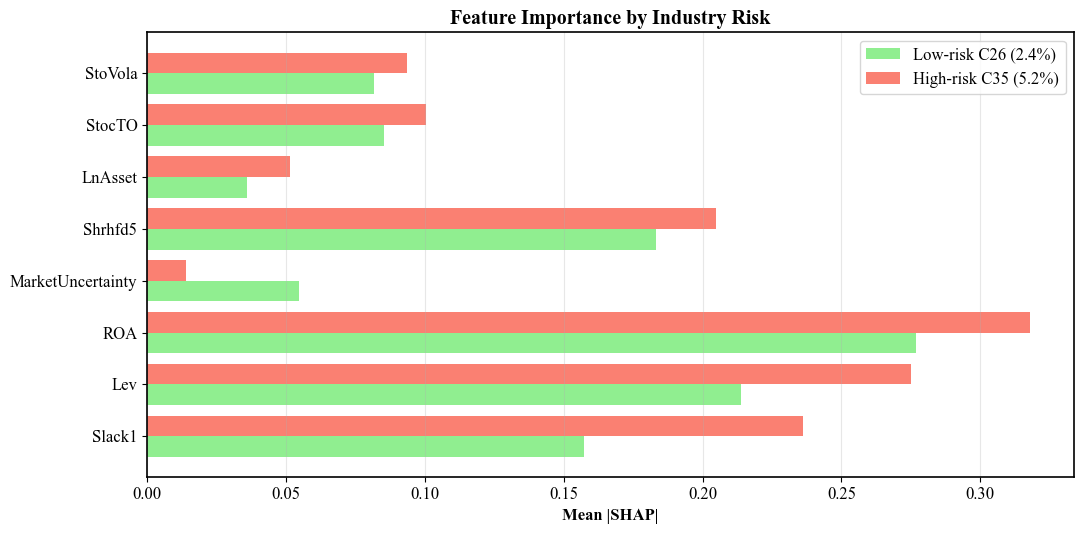

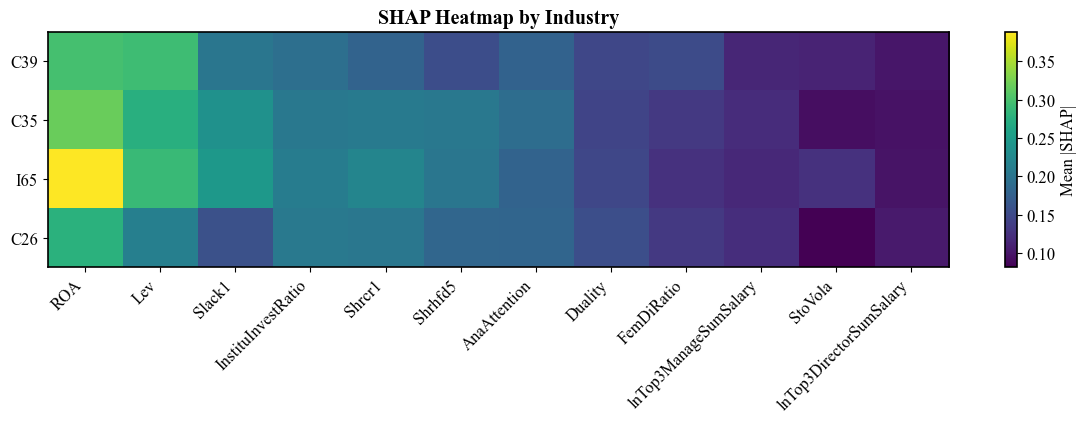

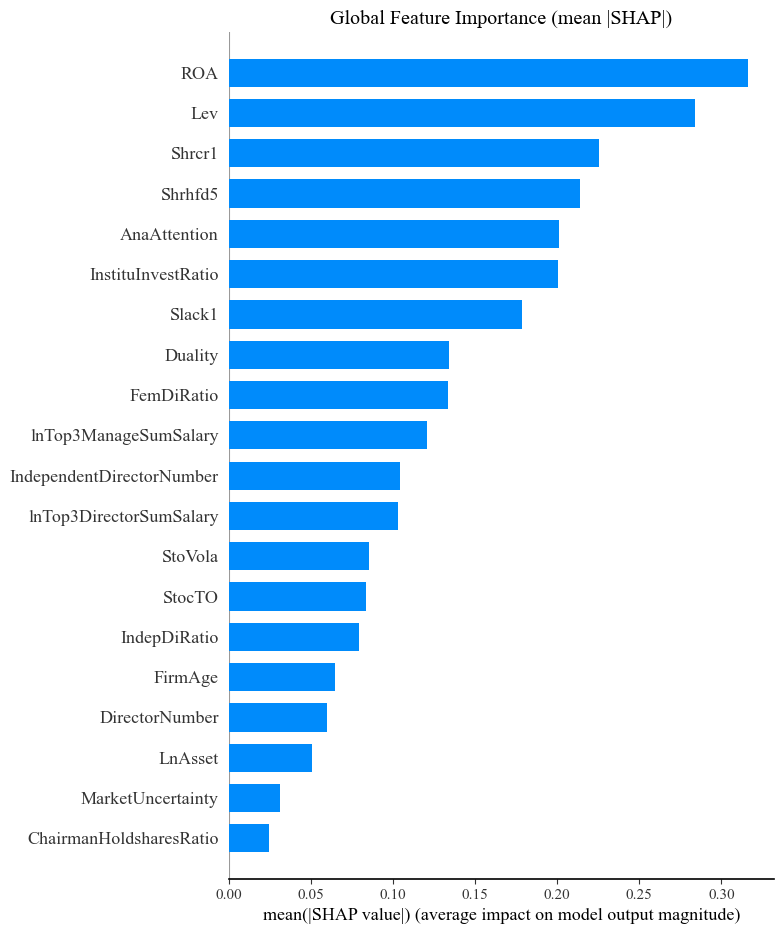

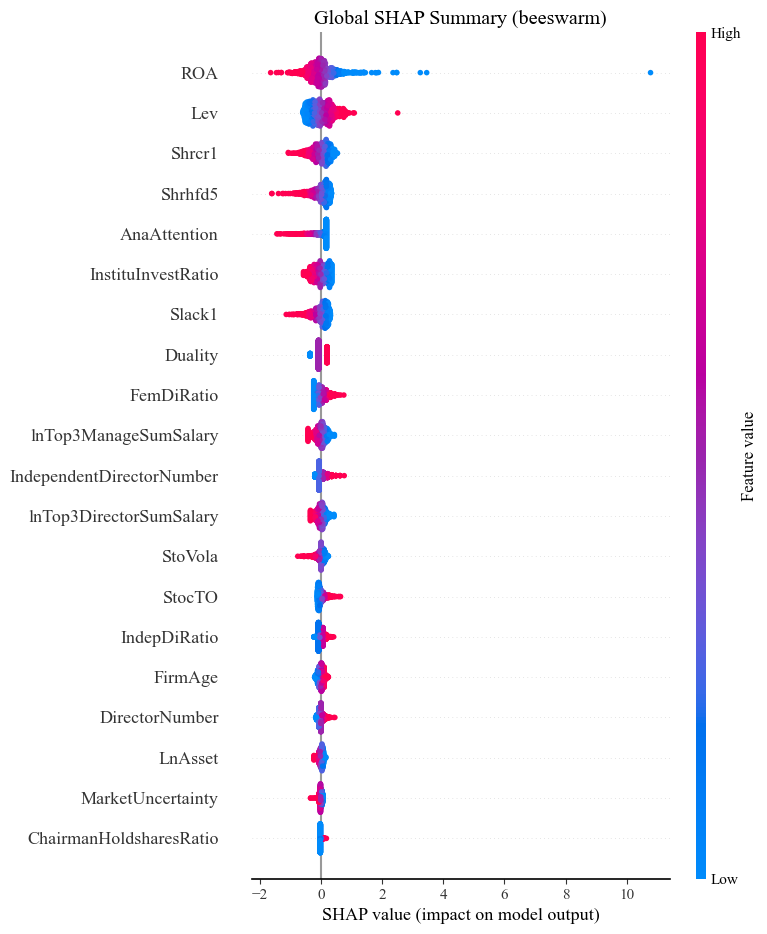

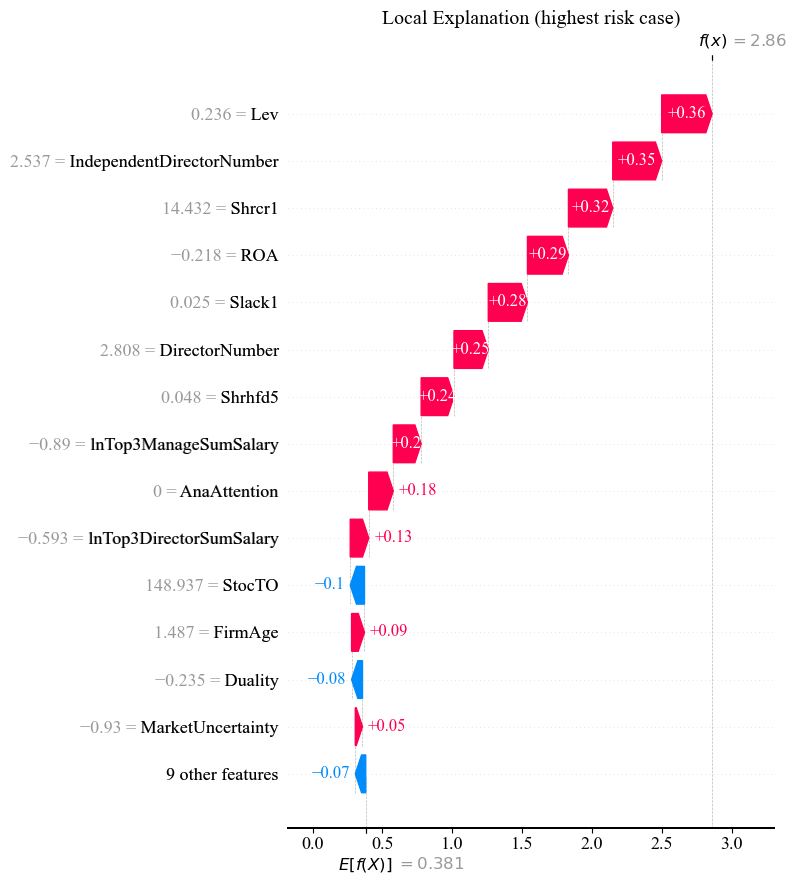

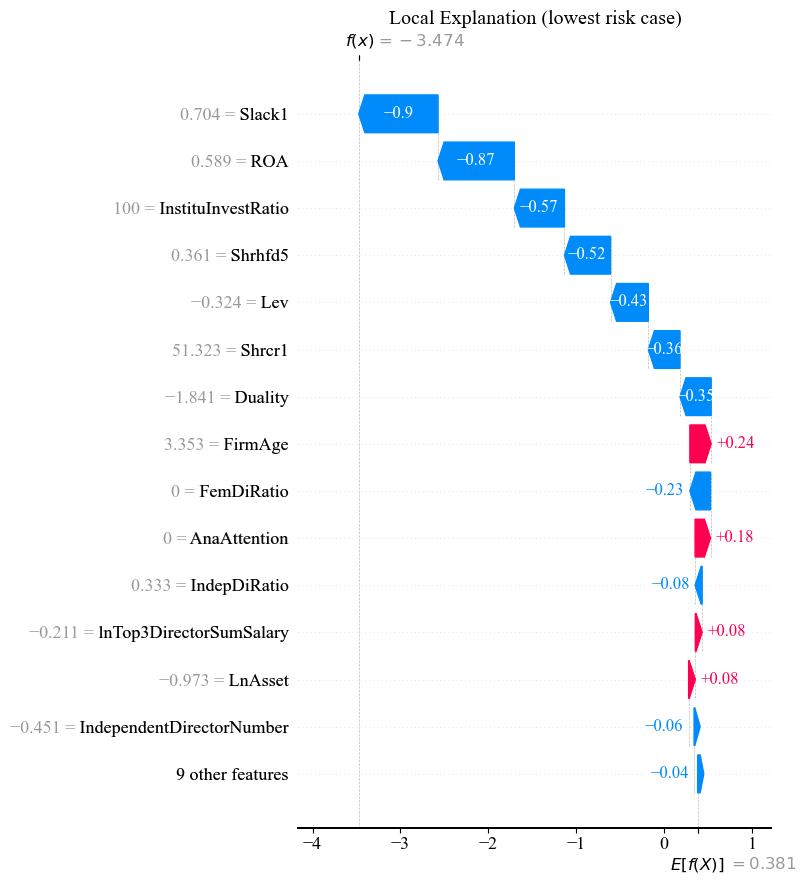


Industries analyzed: 4; Misconduct rate range: 2.4% – 5.2%
SHAP industry-specific interpretation complete.


In [27]:
# ========== Industry-Specific SHAP Analysis ==========
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 12})
np.random.seed(42)

print("=== SHAP-Based Industry Comparison ===")

# 1. Sample a subset of test data for SHAP analysis
best_model = best_result['model']
X_test_use = X_test.copy()
y_test_use = y_test.copy().reset_index(drop=True)

def stratified_sample(X, y, total=1000, min_pos=40, random_state=42):
    rng = np.random.default_rng(random_state)
    y_reset, X_reset = y.reset_index(drop=True), X.reset_index(drop=True)
    pos_idx = y_reset[y_reset == 1].index.to_numpy()
    neg_idx = y_reset[y_reset == 0].index.to_numpy()
    pos_take = min(max(min_pos, int(total * y_reset.mean())), len(pos_idx))
    neg_take = min(total - pos_take, len(neg_idx))
    sel = np.concatenate([
        rng.choice(pos_idx, pos_take, replace=False),
        rng.choice(neg_idx, neg_take, replace=False)
    ])
    return X_reset.iloc[sel], y_reset.iloc[sel], sel

X_samp, y_samp, sampled_idx = stratified_sample(X_test_use, y_test_use)
print(f"Sampled: {len(X_samp)} samples, Misconduct rate: {y_samp.mean():.1%}")

# 2. Align industry code for the sampled observations
industries = df_all.loc[X_test_use.index, 'IndustryCode'].reset_index(drop=True).iloc[sampled_idx].reset_index(drop=True)
y_samp = y_samp.reset_index(drop=True)

# 3. Compute SHAP values
is_tree = any(k in str(type(best_model)) for k in ['Forest', 'XGB', 'Boost'])
if is_tree:
    explainer = shap.TreeExplainer(best_model)
    shap_vals = explainer.shap_values(X_samp)
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]  # class-1
else:
    proba = best_model.predict_proba(X_samp)[:, 1]
    Xs = (X_samp - X_samp.mean()) / (X_samp.std(ddof=0) + 1e-9)
    corr = Xs.apply(lambda c: np.corrcoef(c, proba)[0, 1] if c.std() > 0 else 0.0)
    shap_vals = (Xs.values * corr.values).astype(float)

shap_vals = np.asarray(shap_vals)
if shap_vals.ndim == 3:
    shap_vals = shap_vals[:, :, 1]
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(1, -1)

# 4. Aggregate SHAP values by industry
features = np.array(selected_features)
industry_data = {}
major_inds = industries.value_counts()[industries.value_counts() >= 20].index[:4]

for ind in major_inds:
    mask = (industries == ind).to_numpy()
    vals = shap_vals[mask]
    vals = vals.reshape(vals.shape[0], -1)
    abs_mean = np.mean(np.abs(vals), axis=0)
    signed_mean = np.mean(vals, axis=0)
    top_idx = np.argsort(abs_mean)[::-1][:5]
    
    print(f"\nIndustry {ind} (n={mask.sum()}, Misconduct rate = {y_samp[mask].mean():.1%})")
    for r, j in enumerate(top_idx, 1):
        arrow = "↑" if signed_mean[j] > 0 else "↓"
        print(f"  {r}. {features[j]:<20} {abs_mean[j]:.4f} {arrow}")
    
    industry_data[ind] = dict(
        importance=abs_mean,
        mean_shap=signed_mean,
        rate=y_samp[mask].mean()
    )

# 5. Compare high-risk vs low-risk industries
if len(industry_data) >= 2:
    sorted_inds = sorted(industry_data.items(), key=lambda x: x[1]['rate'])
    low, high = sorted_inds[0], sorted_inds[-1]
    diff = np.abs(high[1]['importance'] - low[1]['importance'])
    top_idx = np.argsort(diff)[::-1][:8]

    print("\n=== High vs. Low Risk Industry Comparison ===")
    for i, j in enumerate(top_idx, 1):
        direction = "higher" if high[1]['importance'][j] > low[1]['importance'][j] else "lower"
        print(f"  {i}. {features[j]:<20} Δ{diff[j]:.4f} ({direction} in high-risk)")

    plt.figure(figsize=(11, 5.5))
    y_pos = np.arange(len(top_idx))
    plt.barh(y_pos - 0.2, low[1]['importance'][top_idx], 0.4,
             label=f"Low-risk {low[0]} ({low[1]['rate']:.1%})", color="lightgreen")
    plt.barh(y_pos + 0.2, high[1]['importance'][top_idx], 0.4,
             label=f"High-risk {high[0]} ({high[1]['rate']:.1%})", color="salmon")
    plt.yticks(y_pos, features[top_idx])
    plt.xlabel("Mean |SHAP|", fontweight="bold")
    plt.title("Feature Importance by Industry Risk", fontweight="bold")
    plt.legend()
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

# 6. Optional heatmap across industries
if len(industry_data) >= 2:
    inds = list(industry_data.keys())
    mat = np.vstack([industry_data[i]['importance'] for i in inds])
    top_global = np.argsort(np.mean(mat, axis=0))[::-1][:12]

    plt.figure(figsize=(12, 0.6 * len(inds) + 2))
    plt.imshow(mat[:, top_global], aspect="auto", cmap="viridis")
    plt.yticks(np.arange(len(inds)), inds)
    plt.xticks(np.arange(12), features[top_global], rotation=45, ha="right")
    plt.colorbar(label="Mean |SHAP|")
    plt.title("SHAP Heatmap by Industry", fontweight="bold")
    plt.tight_layout()
    plt.show()

# 7. Global SHAP importance
try:
    plt.figure(figsize=(8, 5))
    shap.summary_plot(shap_vals, X_samp, feature_names=selected_features, plot_type="bar", show=False)
    plt.title("Global Feature Importance (mean |SHAP|)")
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_vals, X_samp, feature_names=selected_features, show=False)
    plt.title("Global SHAP Summary (beeswarm)")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("SHAP summary plot skipped:", e)

# 8. Local case explanation
try:
    proba_all = best_result['y_proba'][sampled_idx] if 'sampled_idx' in locals() else best_result['y_proba']
    idx_all = np.argsort(proba_all)
    pick_high = int(idx_all[-1])
    pick_low = int(idx_all[0])

    base_val = None
    if 'explainer' in locals() and hasattr(explainer, 'expected_value'):
        ev = explainer.expected_value
        base_val = (ev[1] if isinstance(ev, (list, np.ndarray)) else ev)

    def show_waterfall(pick_idx, title):
        vals = shap_vals[pick_idx]
        exp = shap.Explanation(
            values=vals,
            base_values=(base_val if base_val is not None else float(np.mean(proba_all))),
            data=X_samp.iloc[pick_idx].values,
            feature_names=selected_features
        )
        plt.figure(figsize=(10, 6))
        shap.plots.waterfall(exp, max_display=15, show=False)
        plt.title(title); plt.tight_layout(); plt.show()

    show_waterfall(pick_high, "Local Explanation (highest risk case)")
    show_waterfall(pick_low,  "Local Explanation (lowest risk case)")
except Exception as e:
    print("Waterfall plots skipped:", e)

# 9. Summary
if len(industry_data) >= 2:
    rates = [v['rate'] for v in industry_data.values()]
    print(f"\nIndustries analyzed: {len(industry_data)}; Misconduct rate range: {min(rates):.1%} – {max(rates):.1%}")
print("SHAP industry-specific interpretation complete.")